In [1]:
import os
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan, run_t_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan

from bmadx.plot import plot_projections
from bmadx.constants import PI

## Create synthetic ground truth beam

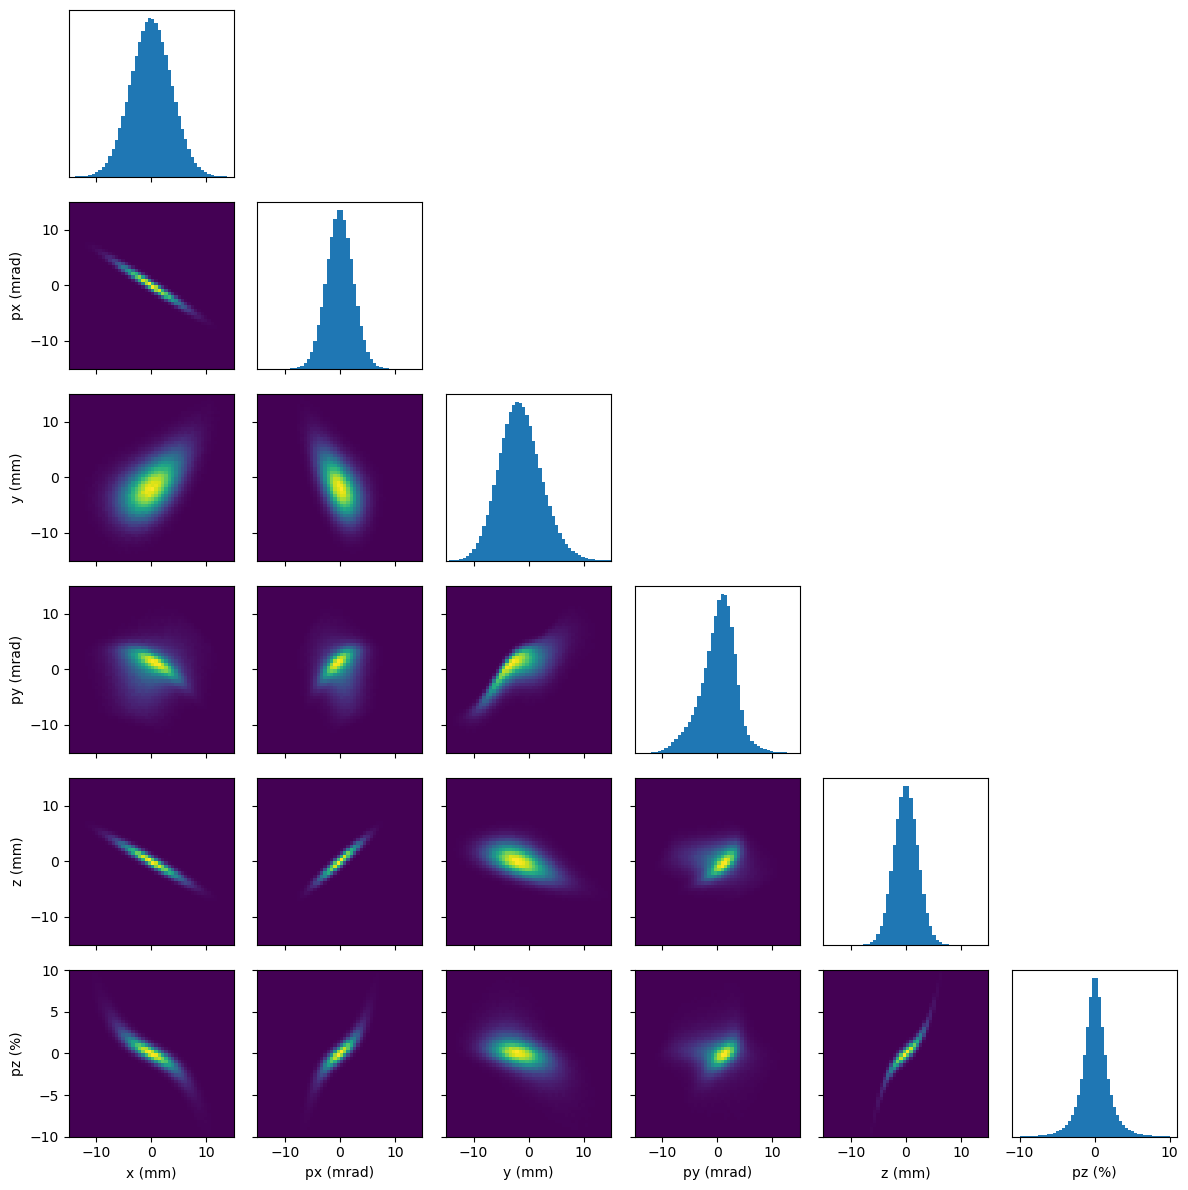

In [2]:
# load ground truth beam
gt = torch.load(os.path.join('data','non_gaussian_beam','stats','non_gaussian_beam.pt'))

# plot gt beam
lims = np.array([[-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-10e-2, 10e-2]]) 
fig, ax = plot_projections(
    gt.numpy_particles(),
    custom_lims = lims,
    background = 0
)
plt.show()

torch.Size([20, 3, 1])
torch.Size([20, 1, 200, 200])


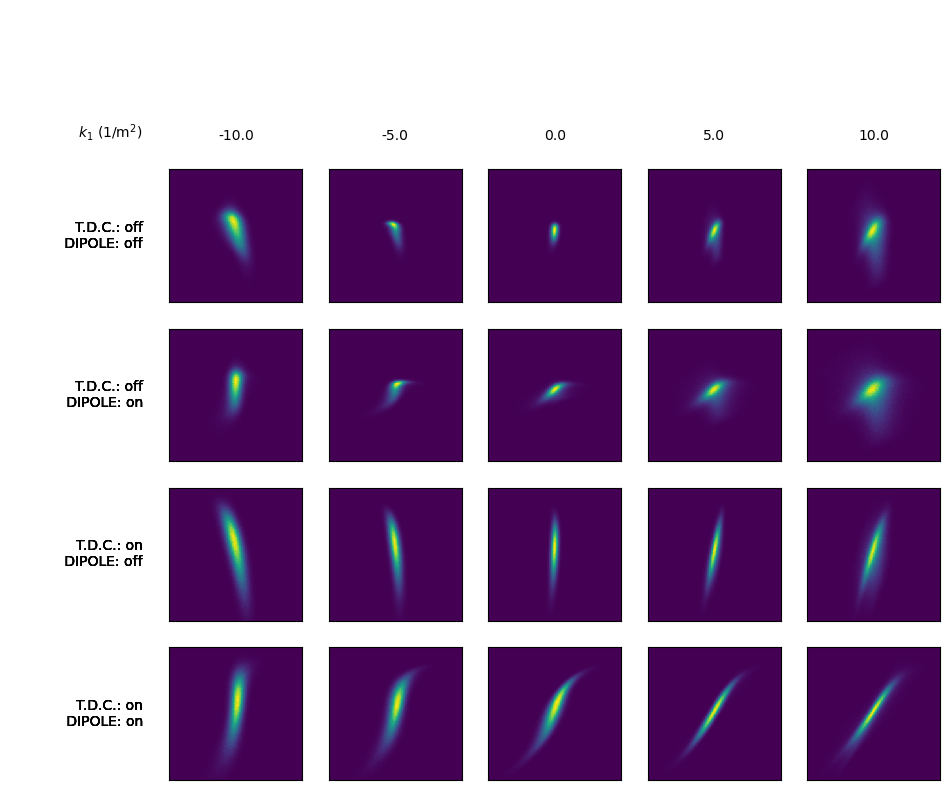

In [3]:
# load train dataset
train_dset = torch.load(os.path.join('data','non_gaussian_beam','stats','3d_scan_train.dset'))
print(train_dset.params.shape)
print(train_dset.images.shape)

# plot training dataset
fig, ax = plot_3d_scan_data(train_dset)
plt.show()

In [4]:
# lattice:
# reference momentum in eV/c
p0c = 43.36e6 

# triplet params obtained from triplet-opt.ipynb
k1 = 7.570125
k2 = -15.704693
k3 = 1.0

# diagnostic beamline:
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
lattice.elements[0].K1.data = torch.tensor(k1)
lattice.elements[2].K1.data = torch.tensor(k2)
lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 5
ks = torch.linspace(-10, 10, n_ks) # quad ks
vs = torch.tensor([0, 5e6]) # TDC off/on
gs = torch.tensor([2.22e-16, 20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))

# create diagnostic screen: 
bins = torch.linspace(-50, 50, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

In [5]:
def train_single_model(seed):
    fname = f'r_{seed}.pt'
    torch.manual_seed(seed)
    pred_beam = train_3d_scan(
        train_dset, 
        lattice, 
        p0c, 
        screen,
        ids = scan_ids,
        n_epochs = 2_000, 
        n_particles = 100_000, 
        device = torch.device('cuda:0'),
        save_as = os.path.join('data','non_gaussian_beam','stats_2',fname)
    )
    torch.cuda.empty_cache()
    
def train_sequentially(seed_initial, seed_final):
    for seed in range(seed_initial, seed_final+1):
        print(f'--------------------')
        print(f'---SEED: {seed}--------')
        print(f'--------------------')
        train_single_model(seed)

In [ ]:
seed_initial = 1
seed_final = 10
train_sequentially(seed_initial, seed_final)

--------------------
---SEED: 1--------
--------------------
Using device: cuda:0


/global/common/software/m669/jpga/conda/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680572619157/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(3312482.2500, device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(470023.4688, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(399156.7812, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(379336.1250, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(376132.6250, device='cuda:0', grad_fn=<MulBackward0>)
500 tensor(316823.5000, device='cuda:0', grad_fn=<MulBackward0>)
600 tensor(372696.2188, device='cuda:0', grad_fn=<MulBackward0>)
700 tensor(262163.7812, device='cuda:0', grad_fn=<MulBackward0>)
800 tensor(325266.4688, device='cuda:0', grad_fn=<MulBackward0>)
900 tensor(281049.4375, device='cuda:0', grad_fn=<MulBackward0>)
1000 tensor(259063.1406, device='cuda:0', grad_fn=<MulBackward0>)
1100 tensor(315041.7812, device='cuda:0', grad_fn=<MulBackward0>)
1200 tensor(286949.4375, device='cuda:0', grad_fn=<MulBackward0>)
1300 tensor(247685.5625, device='cuda:0', grad_fn=<MulBackward0>)
1400 tensor(275088.4062, device='cuda:0', grad_fn=<MulBackward0>)
1500 tensor(245886.21